# Ejercicio k-Nearest Neighbor

## App Reviews
En este ejercicio vas a trabajar con una base de datos de reviews de una aplicación. Entre los datos podemos encontrar el texto de la review, las estrellas, así como el sentimiento del comentario (si es algo bueno o malo).

El objetivo es montar un algoritmo de clasificación que prediga el rating, en función del sentimiento del comentario y la cantidad de palabras empleadas en el mismo. Para ello tendrás que utilizar un algoritmo de tipo KNN.

## Importamos las librerías que vamos a utilizar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, r2_score

# accuracy_score, f1_score - clases balanceadas
# precision_score, recall_score, f1_score, roc_auc_score
# multiclase: f1_score
# detallada: confusion_matrix


## Leemos nuestro archivo de entrada `reviews_sentiment`

In [2]:
df = pd.read_csv('./data/reviews_sentiment.csv', sep=';')
df.head()

,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas...,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784


In [3]:
df = df[['wordcount', 'sentimentValue', 'Star Rating']]
df.head()

,wordcount,sentimentValue,Star Rating
0,23,-0.486389,1
1,20,-0.586187,1
2,4,-0.602240,1
3,17,-0.616271,1
4,6,-0.651784,1


Para facilitar el ejercicio, las columnas que utilizaremos serán: wordcount con la cantidad de palabras utilizadas y sentimentValue con un valor entre -4 y 4 que indica si el comentario fue valorado como positivo o negativo

Nuestras etiquetas, serán las estrellas que dieron los usuarios a la app, que son valores discretos del 1 al 5

## Rápidas visualizaciones y análisis
Al menos realiza un análisis univariante y representa la distribución del rating. Realiza otras visualizaciones para ver la relación de tus datos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wordcount       257 non-null    int64  
 1   sentimentValue  257 non-null    float64
 2   Star Rating     257 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 6.2 KB


In [5]:
df.describe()

,wordcount,sentimentValue,Star Rating
count,257.000000,257.000000,257.000000
mean,11.501946,0.383849,3.420233
std,13.159812,0.897987,1.409531
min,1.000000,-2.276469,1.000000
25%,3.000000,-0.108144,3.000000
50%,7.000000,0.264091,3.000000
75%,16.000000,0.808384,5.000000
max,103.000000,3.264579,5.000000


In [6]:
df.wordcount.value_counts()

wordcount
2      28
1      24
3      21
4      18
5      16
6      16
9      14
7      14
12      9
8       7
23      6
13      6
11      6
20      5
15      5
16      5
17      5
10      5
21      4
22      4
18      4
19      3
27      3
14      3
34      3
63      2
25      2
42      2
49      2
28      2
30      2
29      1
26      1
33      1
45      1
36      1
76      1
32      1
103     1
38      1
52      1
35      1
Name: count, dtype: int64

In [7]:
df.sentimentValue.value_counts()

sentimentValue
-0.139861    4
 2.066294    4
 2.924393    3
-0.083467    2
 0.789284    2
            ..
 2.098547    1
 2.295086    1
 2.333013    1
 2.814818    1
 3.264579    1
Name: count, Length: 241, dtype: int64

In [8]:
df['Star Rating'].value_counts()

Star Rating
5    88
3    78
1    37
4    30
2    24
Name: count, dtype: int64

array([[<Axes: title={'center': 'wordcount'}>,
        <Axes: title={'center': 'sentimentValue'}>],
       [<Axes: title={'center': 'Star Rating'}>, <Axes: >]], dtype=object)

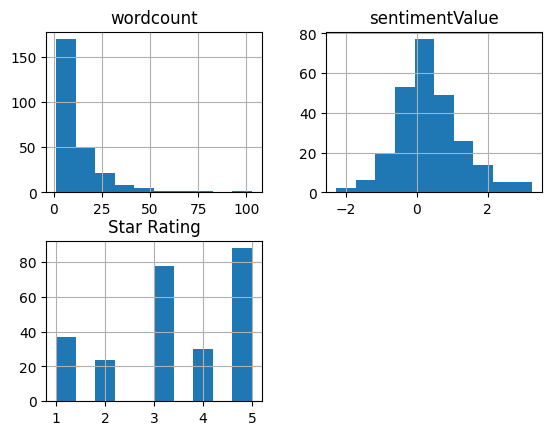

In [9]:
df.hist()

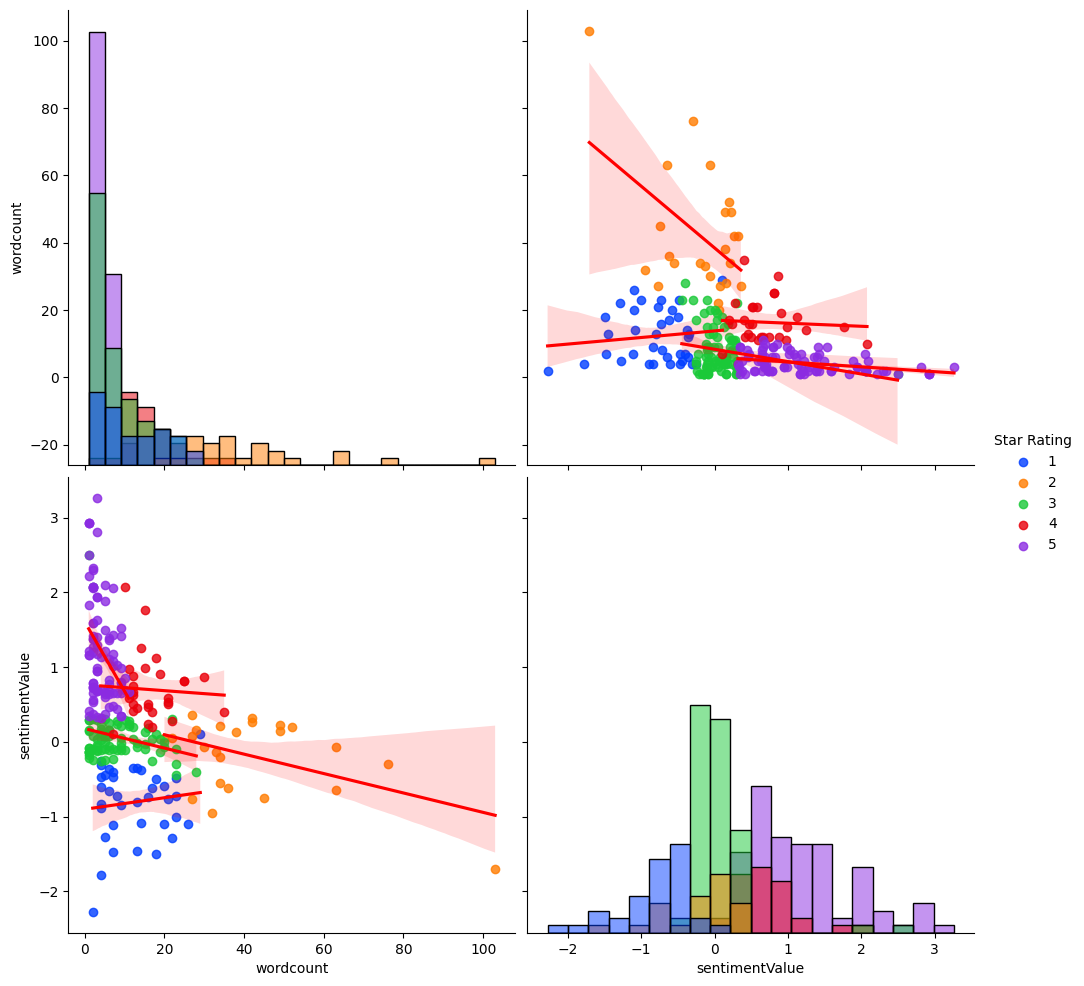

In [10]:
# plt.figure(figsize=(12, 12)) no funciona en pairplot
sns.pairplot(df, kind='reg',hue='Star Rating', diag_kind='hist', plot_kws={"line_kws": {"color": "red"}}, diag_kws={"color": 'green'}, palette='bright', height=5, aspect=1);

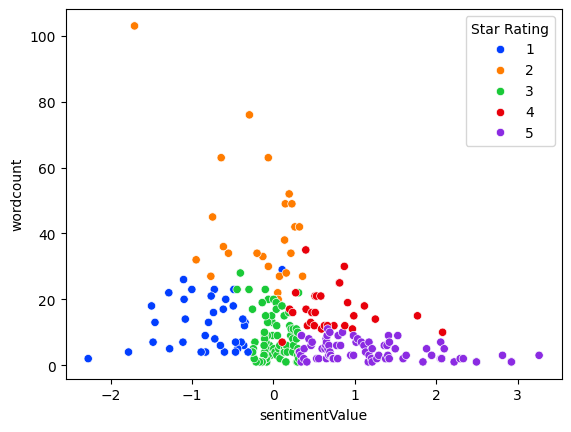

In [11]:
sns.scatterplot(data=df, x=df.sentimentValue, y=df.wordcount, hue=df['Star Rating'], palette='bright');

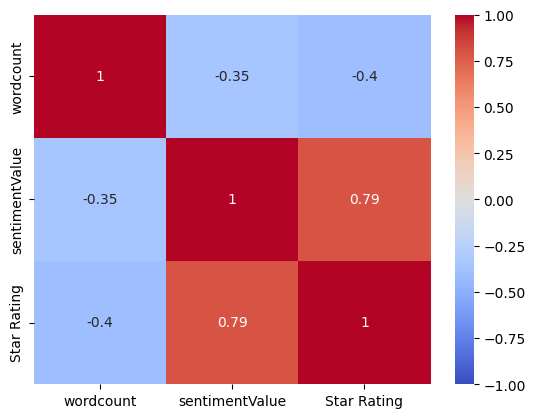

In [12]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", vmin=-1, vmax=1);

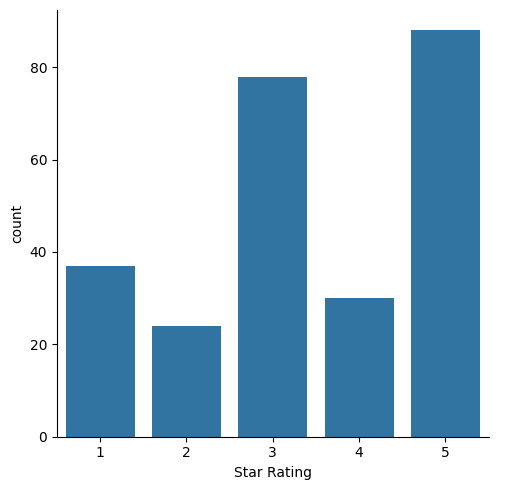

In [13]:
sns.catplot(x='Star Rating', data=df, kind='count')

In [14]:
df.select_dtypes(include='number')

,wordcount,sentimentValue,Star Rating
0,23,-0.486389,1
1,20,-0.586187,1
2,4,-0.602240,1
3,17,-0.616271,1
4,6,-0.651784,1
...,...,...,...
252,3,2.814818,5
253,1,2.924393,5
254,1,2.924393,5
255,1,2.924393,5


## Preparamos el dataset
Divide en train/test y escala las features en el rango [0, 1].

In [15]:
X = df.iloc[:, :-1]
y = df['Star Rating']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(205, 2)
(205,)
(52, 2)
(52,)


In [18]:
mms = MinMaxScaler()
mms.fit(X)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

## Creamos el Modelo
Entrena con un KNN y evalúa el error en train y en test

In [19]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_mms, y_train)


KNeighborsClassifier(n_neighbors=3)

In [20]:

predictions = knn.predict(X_test_mms)
print(accuracy_score(y_test, predictions))


0.8653846153846154


In [21]:
knn.classes_

array([1, 2, 3, 4, 5])

In [22]:
acierto = accuracy_score(y_test, predictions)
error = 1 - acierto

print("acc:", round((acierto * 100)/5, 2),"%")
print("err:", round((error * 100)/5, 2), "%")

acc: 17.31 %
err: 2.69 %


## Evalúa tu modelo

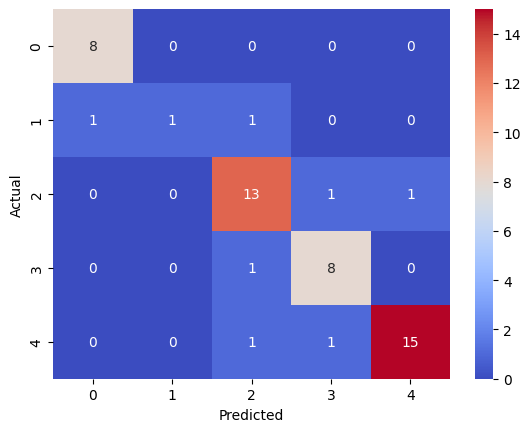

In [23]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm')
plt.xlabel("Predicted")
plt.ylabel("Actual");

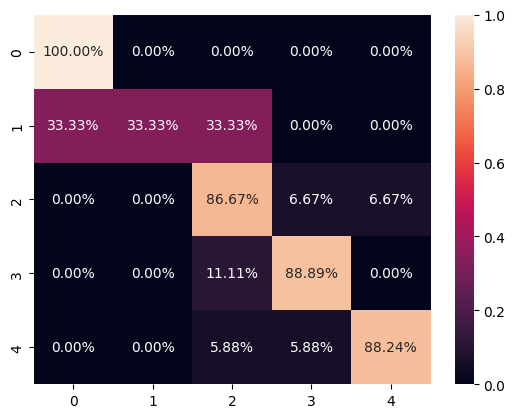

In [24]:
sns.heatmap(confusion_matrix(y_test, predictions, normalize='true'), annot=True, fmt='.2%');

In [25]:
print('precision',  precision_score(y_test, predictions, average='micro'))
print('recall',  recall_score(y_test, predictions, average='micro'))
print('f1',  f1_score(y_test, predictions, average='micro'))

precision 0.8653846153846154
recall 0.8653846153846154
f1 0.8653846153846154


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.89      1.00      0.94         8
           2       1.00      0.33      0.50         3
           3       0.81      0.87      0.84        15
           4       0.80      0.89      0.84         9
           5       0.94      0.88      0.91        17

    accuracy                           0.87        52
   macro avg       0.89      0.79      0.81        52
weighted avg       0.87      0.87      0.86        52



## ¿Cómo obtener el mejor valor de k? Crea y evalúa nuevos modelos
¿Qué valor de k maximiza el accuracy? Representa todas las iteraciones en un scatterplot -> k vs accuracy

In [27]:
knn_gs = KNeighborsClassifier()
k_range = range(1,30)

param_clf = {
    "n_neighbors": k_range
}

gs_knn_clf = GridSearchCV(knn_gs, param_clf, scoring="accuracy")
gs_knn_clf.fit(X_train_mms, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30)}, scoring='accuracy')

In [28]:
print('mejor param:', gs_knn_clf.best_params_['n_neighbors'])
print('mejor accuracy:', gs_knn_clf.best_score_)
print('best estimator', gs_knn_clf.best_estimator_)

mejor param: 3
mejor accuracy: 0.8731707317073172
best estimator KNeighborsClassifier(n_neighbors=3)


In [29]:
model_final = gs_knn_clf.best_estimator_
# model_final.predict --------

model_final.predict(X_test_mms)
print("Accuracy en test:", accuracy_score(y_test, model_final.predict(X_test_mms)))

Accuracy en test: 0.8653846153846154


se me ha olvidado el scatter

In [30]:
k_range = range(1, 30)
scores = []

for i in k_range:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_mms, y_train)
    pred_score = knn.score(X_test_mms, y_test)
    scores.append(pred_score)

print(scores)

[0.8653846153846154, 0.8269230769230769, 0.8653846153846154, 0.8846153846153846, 0.8653846153846154, 0.8653846153846154, 0.8653846153846154, 0.8846153846153846, 0.8653846153846154, 0.8846153846153846, 0.8653846153846154, 0.8846153846153846, 0.8269230769230769, 0.8269230769230769, 0.8269230769230769, 0.8269230769230769, 0.8269230769230769, 0.8269230769230769, 0.8269230769230769, 0.8269230769230769, 0.8269230769230769, 0.8269230769230769, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077]


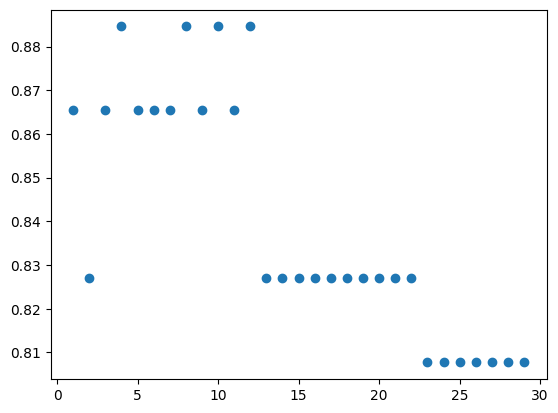

In [31]:
plt.scatter(k_range, scores)  # segun este el el 4 ... no entiendo porque

In [32]:
np.array(k_range)[scores == np.max(scores)]

array([ 4,  8, 10, 12])

## Predice con nuevos datos.
Ejemplo: supongamos que nos llega una review de 5 palabras y sentimiento 1

In [33]:
to_predict = [[5, 1]]

to_predict_mms = mms.transform(to_predict)
to_predict_mms


c:\Users\Ana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.03921569, 0.59130859]])

In [34]:
model_final.predict(to_predict_mms)

array([5])

In [35]:
predict_probab = knn.predict_proba(mms.transform(to_predict))
print(predict_probab)

[[0.         0.         0.         0.03448276 0.96551724]]


c:\Users\Ana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
